## Write SEG-Y with `obspy`

Before going any further, you might like to know, [What is SEG-Y?](http://www.agilegeoscience.com/blog/2014/3/26/what-is-seg-y.html). See also the articles in [SubSurfWiki](http://www.subsurfwiki.org/wiki/SEG_Y) and [Wikipedia](https://en.wikipedia.org/wiki/SEG_Y).

We'll use the [obspy](https://github.com/obspy/obspy) seismology library to read and write SEGY data.
    
Technical SEG-Y documentation:

* [SEG-Y Rev 1](http://seg.org/Portals/0/SEG/News%20and%20Resources/Technical%20Standards/seg_y_rev1.pdf)
* [SEG-Y Rev 2 proposal](https://www.dropbox.com/s/txrqsfuwo59fjea/SEG-Y%20Rev%202.0%20Draft%20August%202015.pdf?dl=0) and [draft repo](http://community.seg.org/web/technical-standards-committee/documents/-/document_library/view/6062543)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ls -l ../data/*.sgy

-rw-r--r--@ 1 matt  staff     256732 27 Aug  2015 ../data/F3_very_small.sgy
-rw-r--r--@ 1 matt  staff   48281760 28 Aug  2015 ../data/HUN00-ALT-01_STK.sgy
-rw-r--r--@ 1 matt  staff     888000  6 Sep 16:01 ../data/Marmousi.sgy
-rw-r--r--@ 1 matt  staff  474438768 25 Aug  2015 ../data/Nova_Scotia.sgy
-rw-r--r--@ 1 matt  staff  359620364 12 Sep 16:23 ../data/Penobscot_0-1000ms.sgy
-rw-r--r--@ 1 matt  staff   48281760 14 Sep 10:43 ../data/out.sgy


## 2D data

In [3]:
filename = '../data/HUN00-ALT-01_STK.sgy'

In [4]:
from obspy.io.segy.segy import _read_segy
section = _read_segy(filename)  # unpack_headers=True slows you down here

In [5]:
data = np.vstack([t.data for t in section.traces])

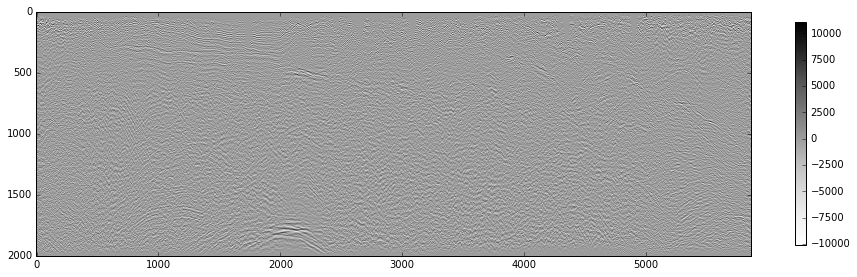

In [6]:
plt.figure(figsize=(16,8))
plt.imshow(data.T, cmap="Greys")
plt.colorbar(shrink=0.5)
plt.show()

Formatted header:

In [7]:
def chunk(string, width=80):
    lines = int(np.ceil(len(string) / width))
    result = ''
    for i in range(lines):
        line = string[i*width:i*width+width]
        result += line + (width-len(line))*' ' + '\n'
    return result

s = section.textual_file_header.decode()
print(chunk(s))

C01  PROCESSED BY: VERITAS GEOSERVICES LTD.                                     
C02  CLIENT      : HUNT OIL COMPANY                                             
C03  AREA        : ALTON                                                        
C04  LINE        : ALT-01                                                       
C05  DATA   NOISE ATTENUATED STRUCTURE STACK                                    
C06         (FILTERED/SCALED)                                                   
C07                                                                             
C08                                                                             
C09  SAMPLE RATE   2 MS.                                                        
C10  FIELD DATA LENGTH 3.0 SEC.; (PROCESSED TO 2.0 SEC)                         
C11  PROCESSING SEQUENCE:                                                       
C12  DEMULTIPLEX:SAMPLE RATE:1 MS RECORD LEN.:3 SEC.S                           
C13  GEOMETRY               

## Change the data

Let's scale the data.

In [8]:
scaled = data / 1000
scaled[np.isnan(scaled)] = 0

In [9]:
scaled

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.0620006 ,
        -0.11197116, -0.14608523],
       [ 0.        ,  0.        ,  0.        , ...,  0.03547406,
         0.04016089,  0.0383723 ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.20556137,
         0.19266182,  0.168312  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.18680261,
         0.16577934,  0.12612453],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

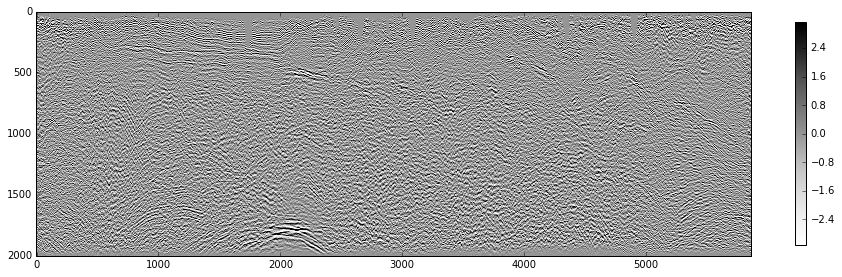

In [10]:
vm = np.percentile(scaled, 99)

plt.figure(figsize=(16,8))
plt.imshow(scaled.T, cmap="Greys", vmin=-vm, vmax=vm)
plt.colorbar(shrink=0.5)
plt.show()

## Write data

Let's write this all back to a new SEG-Y file.

In [11]:
from obspy.core import Trace, Stream, UTCDateTime
from obspy.io.segy.segy import SEGYTraceHeader

In [12]:
stream = Stream()

for i, trace in enumerate(scaled):

    # Make the trace.
    tr = Trace(trace)

    # Add required data.
    tr.stats.delta = 0.004
    tr.stats.starttime = 0  # Not strictly required.

    # Add yet more to the header (optional).
    tr.stats.segy = {'trace_header': SEGYTraceHeader()}
    tr.stats.segy.trace_header.trace_sequence_number_within_line = i + 1
    tr.stats.segy.trace_header.receiver_group_elevation = 0

    # Append the trace to the stream.
    stream.append(tr)

In [13]:
stream

5859 Trace(s) in Stream:

Seq. No. in line:    1 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:07.996000Z | 250.0 Hz, 2000 samples
...
(5857 other traces)
...
Seq. No. in line: 5859 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:07.996000Z | 250.0 Hz, 2000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [14]:
stream.write('../data/out.sgy', format='SEGY', data_encoding=5)  # encode 5 for IEEE

## Add a file-wide header

So far we only attached metadata to the traces, but we can do more by attaching some filewide metadata, like a textual header. A SEGY file normally has a file wide text header. This can be attached to the stream object.

If this header and the binary header are not set, they will be autocreated with defaults.

In [15]:
from obspy.core import AttribDict
from obspy.io.segy.segy import SEGYBinaryFileHeader

In [16]:
# Text header.
stream.stats = AttribDict()
stream.stats.textual_file_header = '{:80s}'.format('This is the textual header.').encode()
stream.stats.textual_file_header += '{:80s}'.format('This file contains seismic data.').encode()

# Binary header.
stream.stats.binary_file_header = SEGYBinaryFileHeader()
stream.stats.binary_file_header.trace_sorting_code = 4
stream.stats.binary_file_header.seg_y_format_revision_number = 0x0100

In [17]:
import sys
stream.write('../data/out.sgy', format='SEGY', data_encoding=5, byteorder=sys.byteorder)

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2016</p>
</div>